# UV excess in low mass stars

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV excess in low mass stars
- Learn how to use a GUVcat catalog query and make selection cuts
- Create a light curve out of gPhoton
- **Tentatively**: add Swift UVOT time-tagged observations based on metadata (depending on length of tutorial)
- **Tentatively**: add PS1 time series for low-cadence but longer baselines and multicolor (depending on length of tutorial)

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. Additionally, this survey has additionally been used to <a href="https://ui.adsabs.harvard.edu/abs/2008ApJ...689.1274S/abstract">accrete binaries</a> or <a href="https://ui.adsabs.harvard.edu/abs/2017ApJ...841...33M/abstract">AGB chromospheres</a>.

**Light curve background**: a light curve represents the brightness variation of an object studied over a period of time. This tool is simple but powerful, especially useful for time-variable objects such as supernovae or variable stars. The plot can show brightness (magnitude) over time, but it can also be represented as any other measure of brightness, such as the count of the number of X-rays over time.

**Defining some terms**:
- **AGB**: Asymptotic Giant Branch. This corresponds to an area of the Herzsprung-Russell diagram where evolved cool luminous stars are found, all low to intermediate mass (0.5-8 solar masses) undergo this period of stellar evolution.

## Imports

- _gPhoton_ for querying the GALEX database and making light curves.
- _pandas_ for working with data sets in csv format.
- _matplotlib.pyplot_ for plotting data.

In [23]:
import gPhoton
import pandas as pd
import matplotlib.pyplot as plt

_**Warning**: you may need to donwload gPhoton if you have not installed it previously, information about how to install it can be found in the following <a href="https://archive.stsci.edu/prepds/gphoton/#installation">link</a>_.

## Querying GALEX database

In order to query _GALEX_, we will use the _gFind_ module from _gPhoton_. _gFind_ queries the database by coordinates and reports back any available data; the data is reported back as available time exposures.

Let's look for the target _G 125-36_ which coordinates are: 19º 50' 15".93 31º 46' 59".9 (J200, 2MASS).

_**Heads-up**: skyposition should be used as input in decimal degrees._

In [17]:
gPhoton.gFind(band='NUV',skypos=[19.83776,31.78331],maxgap=100.,minexp=100.)

NUV: 2281.0s (raw) in 5 exposures.
    [ 746219034.995, 746219155.995 ], 121.000 seconds
    [ 847123613.995, 847123722.995 ], 109.000 seconds
    [ 907942175.995, 907942407.995 ], 232.000 seconds
    [ 908368131.995, 908368362.995 ], 231.000 seconds
    [ 935277833.995, 935279421.995 ], 1588.000 seconds


{'NUV': {'expt': 2281.0,
  't0': array([7.46219035e+08, 8.47123614e+08, 9.07942176e+08, 9.08368132e+08,
         9.35277834e+08]),
  't1': array([7.46219156e+08, 8.47123723e+08, 9.07942408e+08, 9.08368363e+08,
         9.35279422e+08]),
  'nearest_source': {'mag': 23.70927,
   'skypos': [19.8401216146914, 31.7836149319057],
   'distance': 0.0020305053850481845}}}

## Downloading its corresponding light curve

Now that we have confirmed the target is included in the GALEX database, let's download its lightcurve using _gAperture_ from _gPhoton_. The output will be written to a _.csv_ file with the name of our choice that we can specify using the _csvfile_ parameter.

In [27]:
%%time

gPhoton.gAperture(band='NUV', skypos=[19.83776,31.78331], stepsz=10.,
          csvfile='g_125_36_nuv.csv', radius=0.012,
          trange=[935277833.995,935279421.995])

CPU times: user 48.3 s, sys: 2.76 s, total: 51.1 s
Wall time: 7min 41s


{'params': {'band': 'NUV',
  'ra0': 19.83776,
  'dec0': 31.78331,
  'skypos': [19.83776, 31.78331],
  'trange': [935277833.99, 935279421.99],
  'radius': 0.012,
  'annulus': None,
  'stepsz': 10.0,
  'verbose': 0,
  'detsize': 1.25,
  'apcorrect1': 0.02240000000000001,
  'apcorrect2': 0.04,
  'detbg': 2.6057626105935174,
  'n_apersources': 12,
  'n_bgsources': None,
  'max_bgmag': None,
  'version': '1.28.9'},
 't0': array([9.35277834e+08, 9.35277844e+08, 9.35277854e+08, 9.35277864e+08,
        9.35277874e+08, 9.35277884e+08, 9.35277894e+08, 9.35277904e+08,
        9.35277914e+08, 9.35277924e+08, 9.35277934e+08, 9.35277944e+08,
        9.35277954e+08, 9.35277964e+08, 9.35277974e+08, 9.35277984e+08,
        9.35277994e+08, 9.35278004e+08, 9.35278014e+08, 9.35278024e+08,
        9.35278034e+08, 9.35278044e+08, 9.35278054e+08, 9.35278064e+08,
        9.35278074e+08, 9.35278084e+08, 9.35278094e+08, 9.35278104e+08,
        9.35278114e+08, 9.35278124e+08, 9.35278134e+08, 9.35278144e+08,
    

## Reading the _.csv_ file using pandas

Reading _.csv_ files is straight forwards by using the _read_csv_ function from <a href="https://pandas.pydata.org">_pandas_</a>.

In [21]:
lightcurve_g_125_36 = pd.read_csv("g_125_36_nuv.csv")
lightcurve_g_125_36

,t0,t1,t_mean,t0_data,t1_data,cps_bgsub,cps_bgsub_err,flux_bgsub,flux_bgsub_err,mag_bgsub,...,bg,mcat_bg,responses,detxs,detys,detrad,racent,deccent,q_mean,flags
0,9.352778e+08,9.352778e+08,9.352778e+08,9.352778e+08,9.352778e+08,8.007373,0.954926,1.649519e-15,1.967148e-16,17.821275,...,0.0,72.054729,0.810876,444.443420,190.407043,214.253180,19.838395,31.783380,13.052631,0.0
1,9.352778e+08,9.352779e+08,9.352778e+08,9.352778e+08,9.352779e+08,9.319600,1.029548,1.919838e-15,2.120869e-16,17.656507,...,0.0,72.146620,0.805870,444.396393,191.696533,212.982098,19.837762,31.783228,12.681818,0.0
2,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,8.036688,0.956010,1.655558e-15,1.969381e-16,17.817307,...,0.0,72.154612,0.806961,444.394714,194.317612,210.418952,19.839387,31.783418,11.859649,0.0
3,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,8.741008,0.996816,1.800648e-15,2.053442e-16,17.726096,...,0.0,72.184363,0.806574,444.112335,193.924026,210.744407,19.836334,31.783581,12.387096,0.0
4,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,9.352779e+08,8.103082,0.959710,1.669235e-15,1.977004e-16,17.808374,...,0.0,72.190785,0.799864,444.555786,195.114975,209.673774,19.837234,31.783909,12.105263,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,7.711453,0.935905,1.588559e-15,1.927964e-16,17.862159,...,0.0,72.241139,0.810357,446.278412,184.146042,220.759196,19.837945,31.783628,10.654546,0.0
155,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,6.888584,0.884622,1.419048e-15,1.822321e-16,17.984675,...,0.0,72.231484,0.808333,442.171082,183.440933,220.626901,19.836295,31.782932,10.632653,0.0
156,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.686359,1.049218,1.995390e-15,2.161388e-16,17.614599,...,0.0,72.200717,0.809823,439.575439,185.852203,217.773952,19.837239,31.783628,10.768116,0.0
157,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.352794e+08,9.695920,1.050618,1.997360e-15,2.164272e-16,17.613527,...,0.0,72.079496,0.810360,437.815582,189.795013,213.579387,19.837835,31.783502,11.289855,0.0


## Plotting the light curve

Once we have loaded the _csv_ file, we can create a figure of the flux versus the time in the following way:

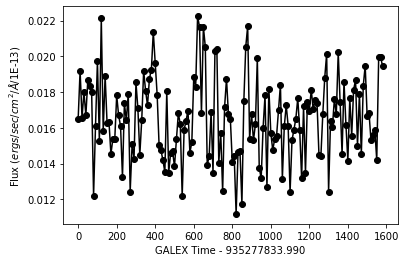

In [26]:
plt.figure()
plt.plot(lightcurve_g_125_36.t0 - lightcurve_g_125_36.t0[0],lightcurve_g_125_36.flux_bgsub/1e-13,'ko')
plt.plot(lightcurve_g_125_36.t0 - lightcurve_g_125_36.t0[0],lightcurve_g_125_36.flux_bgsub/1e-13,'k')
plt.xlabel('GALEX Time - %.3f'%lightcurve_g_125_36.t0[0])
plt.ylabel('Flux ($ergs/sec/cm^2/\AA$/1E-13)')
plt.show()

## Exercises

## Additional Resources

For more information about the MAST archive and details about mission data: 

<a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
<a href="https://archive.stsci.edu/hlsp/guvcat">GALEX UV Unique Source Catalogs</a> <br> 
<a href="https://archive.stsci.edu/prepds/gphoton/">gPhoton: A Time-Tagged Database Of Every GALEX Photon Event</a>

For more information about light curves:

<a href="https://imagine.gsfc.nasa.gov/science/toolbox/timing1.html">Light Curves and What They Can Tell Us</a> 

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Updated on**: 11/07/2022

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>